In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from nuscenes.nuscenes import NuScenes as V2XSimDataset
from mmseg.apis import init_model

from Vehicle.Vehicle import Vehicle
from Registration.utils import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
config_file = '.\\checkpoints\\deepLabv3Plus\\deeplabv3plus_r50-d8_4xb2-40k_cityscapes-512x1024.py'
checkpoint_file = '.\\checkpoints\\deepLabv3Plus\\weights.pth'

model = init_model(config_file, checkpoint_file, device='cuda:0')

c:\Users\konst\anaconda3\envs\thesis\lib\site-packages\mmseg\models\builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
c:\Users\konst\anaconda3\envs\thesis\lib\site-packages\mmseg\models\losses\cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: .\checkpoints\deepLabv3Plus\weights.pth


In [4]:
datapath = "D:\\Dataset-Thesis\\temp\\V2X Sim Mini\\V2X-Sim-2.0-mini"
v2x_sim = V2XSimDataset(version='v2.0-mini', dataroot=datapath, verbose=True)

Loading NuScenes tables for version v2.0-mini...
Loading nuScenes-lidarseg...
32 category,
5 attribute,
4 visibility,
157 instance,
130 sensor,
130 calibrated_sensor,
13000 ego_pose,
12 log,
1 scene,
100 sample,
13000 sample_data,
15292 sample_annotation,
3 map,
600 lidarseg,
Done loading in 0.558 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [5]:
#v1_ID, v2_ID, time
examples = [[1,4, 1], #-> correct
            [1,4,70], #-> correct
            [2,5,85], #-> correct
            [1,5,30], #-> incorrect
            [4,5,90], #-> correct
            [1,2,85]] #-> correct

In [6]:
exaplme_ID = 4 #change this, if you want different example
v1_ID, v2_ID, time = examples[exaplme_ID]

In [7]:
v1 = Vehicle(v2x_sim,v1_ID)
v2 = Vehicle(v2x_sim,v2_ID)

In [10]:
# v2.showVideo('CAM_FRONT', delay=5)
# v2.showVideo('LIADR', delay=5)

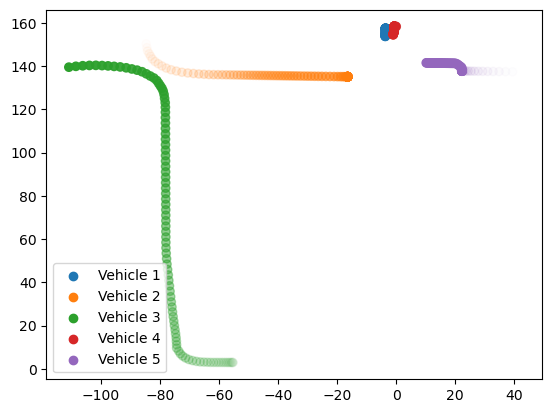

In [62]:
# from Vehicle.utils import plotTrajectory

# vehicles = [Vehicle(v2x_sim,i) for i in range(1, 6)]
# plotTrajectory(vehicles=vehicles)

In [8]:
Scene1, masks1 = v1.generateScene(model, time)
Scene2, masks2 = v2.generateScene(model, time)

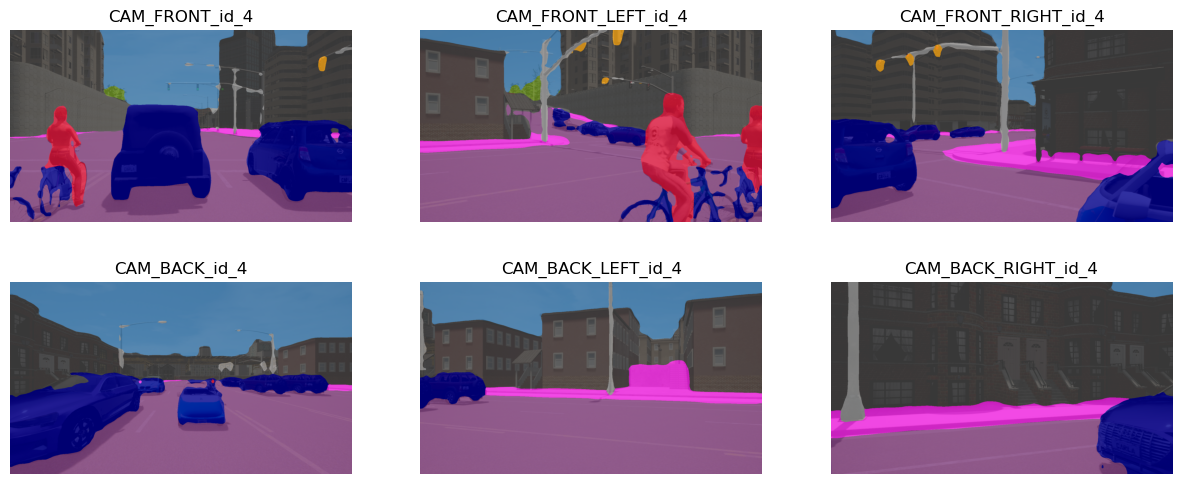

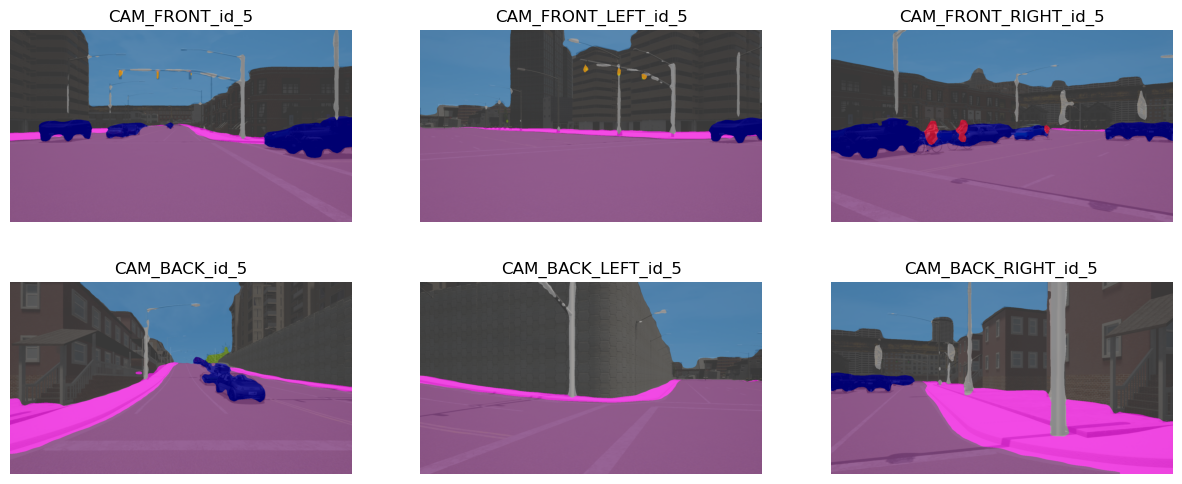

In [9]:
v1.showSegImages(model, time, opacity=0.8, masks=masks1)
v2.showSegImages(model, time, opacity=0.8, masks=masks2)

In [77]:
# Scene1.visualizePCD()
# Scene2.visualizePCD()

In [10]:
cluster_selection_epsilon = 0.5
min_cluster_size = 10 #20

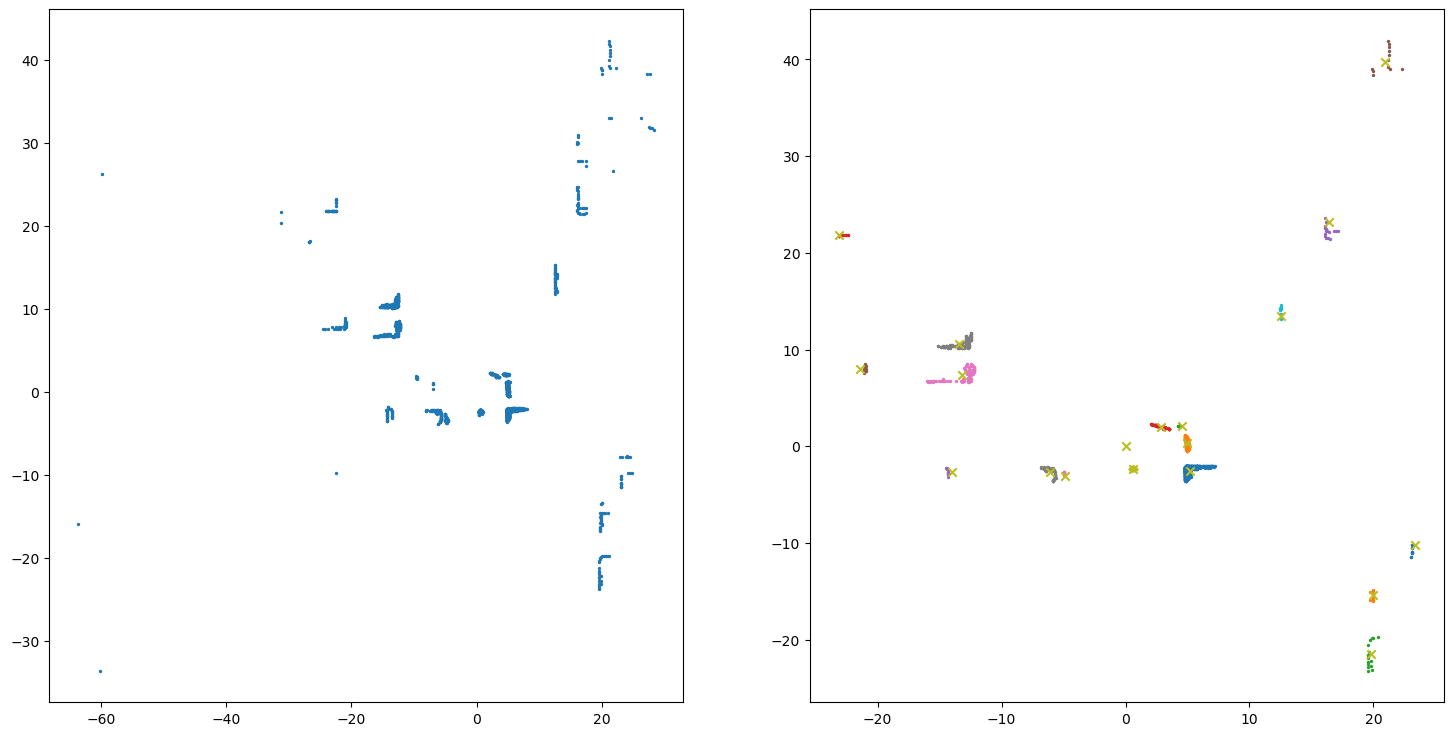

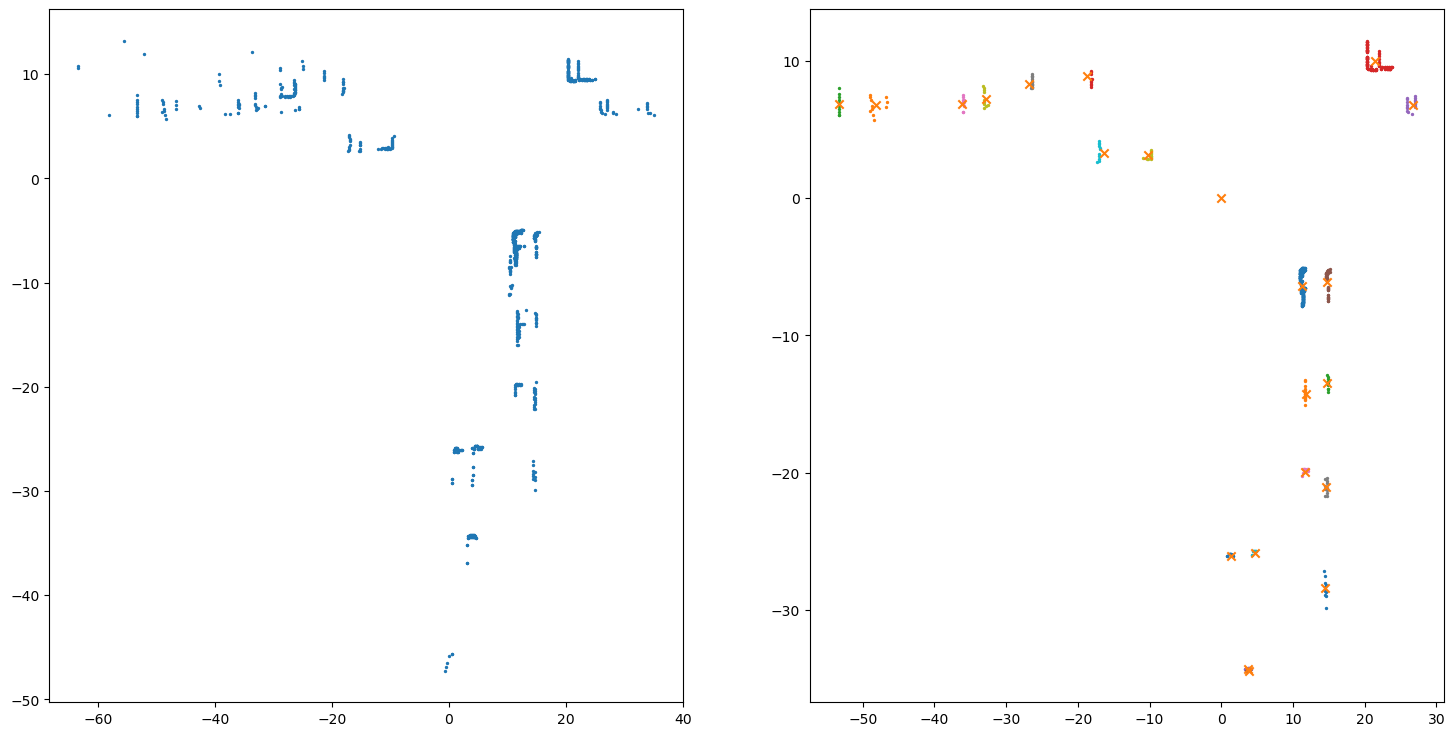

In [11]:
_ = Scene1.findcenters(_min_cluster_size=min_cluster_size, _cluster_selection_epsilon=cluster_selection_epsilon, 
                       className='vehicle', visualize=True)
_ = Scene2.findcenters(_min_cluster_size=min_cluster_size, _cluster_selection_epsilon=cluster_selection_epsilon, 
                       className='vehicle', visualize=True)

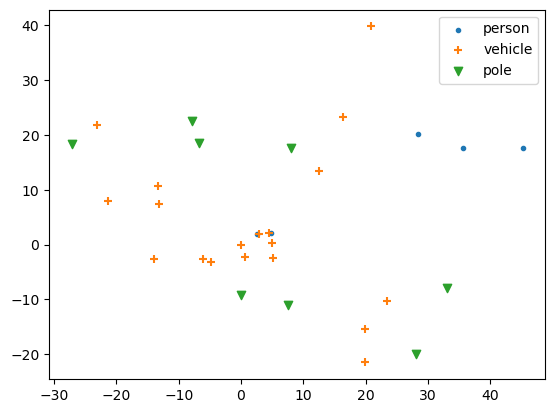

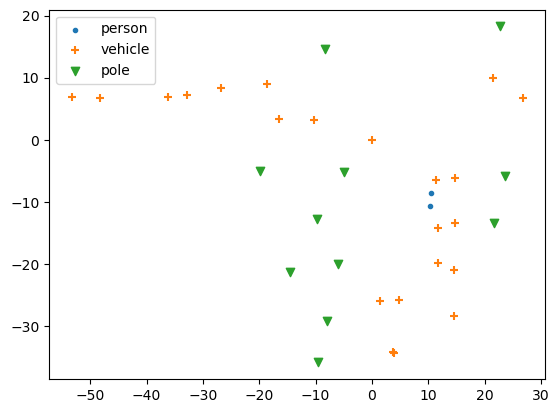

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [10]:
g1 = Scene1.generateGraph(_min_cluster_size=min_cluster_size, _cluster_selection_epsilon=cluster_selection_epsilon,
                          classNames=['person', 'vehicle', 'pole'])
g1.plotGraph()

g2 = Scene2.generateGraph(_min_cluster_size=min_cluster_size, _cluster_selection_epsilon=cluster_selection_epsilon,
                          classNames=['person', 'vehicle', 'pole'])
g2.plotGraph()

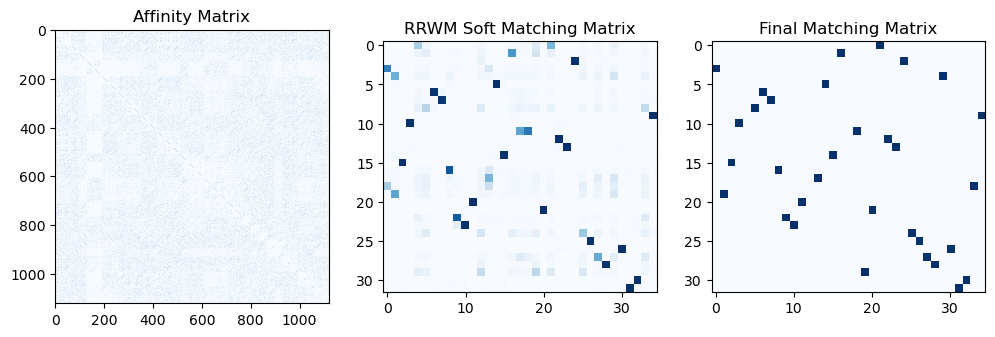

In [11]:
affM, matchMatrix = matchGraph(g1, g2, 1.5)
matchMatrix_final = hardMatch(matchMatrix)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('Affinity Matrix')
plt.imshow(affM, cmap='Blues')
# plt.colorbar()

plt.subplot(1, 3, 2)
plt.title('RRWM Soft Matching Matrix')
plt.imshow(matchMatrix, cmap='Blues')
# plt.colorbar()

plt.subplot(1, 3, 3)
plt.title('Final Matching Matrix')
plt.imshow(matchMatrix_final, cmap='Blues')
# plt.colorbar()

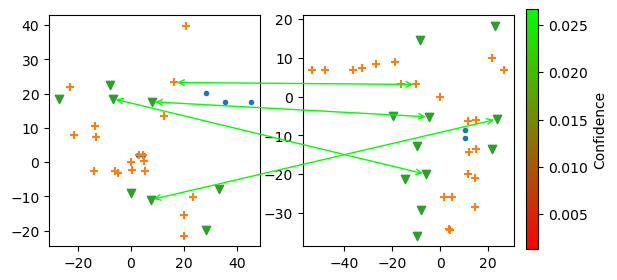

In [120]:
# plotMatching(g1, g2, matchMatrix)
plotMatching(g1, g2, matchMatrix, 4)
#green matches: the good matches
#red matches: the bad matches

In [12]:
TransMatrix_GT = get_GT_tranfMatrix_V1_2_V2(v1, v2, time)
# draw_registration_result(Scene1, Scene2, TransMatrix_GT, False)

In [13]:
TransMatrix = getTransforamtionMatrix_from_MatchingMatrix(g1, g2, matchMatrix, 4)
draw_registration_result(Scene1, Scene2, TransMatrix)
_ = printErrors(TransMatrix_GT, TransMatrix, 'degrees')

det(R) < R, reflection detected!, correcting for it ...
Translation Error:0.39	Axis-X Error:2.45	Axis-Y Error:2.65	Axis-Z Error:0.19


In [14]:
classesICP = ['building', 'pole', 'traffic light', 'person']
regResult = performICP(Scene1, Scene2, TransMatrix, threshold=1, classes=classesICP)
T_final = copy.deepcopy(regResult.transformation)
draw_registration_result(Scene1, Scene2, T_final)
_ = printErrors(TransMatrix_GT, T_final, 'degrees')

Translation Error:1.57	Axis-X Error:2.07	Axis-Y Error:4.95	Axis-Z Error:2.13
